<a href="https://colab.research.google.com/github/dongjun-kor/Python/blob/main/karas_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install keras-bert

In [2]:
import pandas as pd

In [3]:
import os
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [4]:
path = 'gdrive/MyDrive/Colab Notebooks/'

In [5]:
import warnings
warnings.filterwarnings(action='ignore')

In [6]:
import tensorflow as tf

import pandas as pd
import numpy as np
import re
import pickle

import keras as keras
from keras.models import load_model
from keras import backend as K
from keras import Input, Model
from keras import optimizers

import codecs
from tqdm import tqdm
import shutil

In [7]:
from keras_bert import load_trained_model_from_checkpoint, load_vocabulary
from keras_bert import Tokenizer
from keras_bert import AdamWarmup, calc_train_steps

In [8]:
def copytree(src, dst, symlinks=False, ignore = None):
  for item in os.listdir(src):
    s = os.path.join(src, item)
    d = os.path.join(dst, item)
    if os.path.isdir(s):
      shutil.copytree(s, d, symlinks, ignore)
    else:
      shutil.copy2(s, d)

In [10]:
#os.makedirs('bert')
# 존재하면 error 뜸

FileExistsError: ignored

In [12]:
# wget을 활용해서 bert 모델 다운로드 가능
import os
!wget https://storage.googleapis.com/bert_models/2018_11_23/multi_cased_L-12_H-768_A-12.zip

if "bert" not in os.listdir():
  os.makedirs("bert")
else:
  pass

import zipfile
import shutil
         
bert_zip = zipfile.ZipFile('multi_cased_L-12_H-768_A-12.zip')
bert_zip.extractall('bert')
 
bert_zip.close()

def copytree(src, dst, symlinks=False, ignore=None):
    for item in os.listdir(src):
        s = os.path.join(src, item)
        d = os.path.join(dst, item)
        if os.path.isdir(s):
            shutil.copytree(s, d, symlinks, ignore)
        else:
            shutil.copy2(s, d)

copytree("bert/multi_cased_L-12_H-768_A-12", "bert")

--2022-05-02 05:23:40--  https://storage.googleapis.com/bert_models/2018_11_23/multi_cased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.128, 172.217.194.128, 74.125.200.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 662903077 (632M) [application/zip]
Saving to: ‘multi_cased_L-12_H-768_A-12.zip.2’

multi_cased_L-12_H- 100%[===================>] 632.19M   280MB/s    in 2.3s    

2022-05-02 05:23:43 (280 MB/s) - ‘multi_cased_L-12_H-768_A-12.zip.2’ saved [662903077/662903077]



KeyboardInterrupt: ignored

In [11]:
#copytree(os.path.join(path, 'BERT_MODEL'), 'bert')

FileExistsError: ignored

데이터 가져오기

In [14]:
#train = pd.read_csv("/content/gdrive/MyDrive/sIPCcode1.csv",encoding="euc-kr") # train dataset 가져오기
#test =  pd.read_csv("gdrive/MyDrive/Colab Notebooks/Dataset/news_test.csv") # test dataset 가져오기

In [15]:
train = pd.read_table("/content/ratings1.txt")
#test = pd.read_table("nsmc/"+"ratings_test.txt")

In [16]:
train

,id,content,info
0,A01B,SOIL WORKING IN AGRICULTURE OR FORESTRY PARTS...,1
1,A01C,PLANTING SOWING FERTILISING,0
2,A01D,HARVESTING MOWING,1
3,A01F,THRESHING BALING OF STRAW HAY OR THE LIKE ...,0
4,A01G,HORTICULTURE CULTIVATION OF VEGETABLES FLOWE...,1
...,...,...,...
642,H05F,STATIC ELECTRICITY NATURALLY-OCCURRING ELECTR...,0
643,H05G,X-RAY TECHNIQUE,0
644,H05H,PLASMA TECHNIQUE,0
645,H05K,PRINTED CIRCUITS CASINGS OR CONSTRUCTIONAL DE...,0


In [17]:
SEQ_LEN = 128 # 문장 최대 길이
BATCH_SIZE = 16 # Batch size
EPOCHS = 8 # Epochs 
LR = 1e-5 # Learning Rate

pretrained_path = 'gdrive/MyDrive/Colab Notebooks/BERT_MODEL'
config_path = os.path.join(pretrained_path, 'bert_config.json')
checkpoint_path = os.path.join(pretrained_path, 'bert_model.ckpt')
vocab_path = os.path.join(pretrained_path, 'vocab.txt')

DATA_COLUMN = 'content' # 분석할 문장의 Column
LABEL_COLUMN = 'info' # Label Column

In [18]:
LABEL_COLUMN = 'info' # Label Column

token_dict = {}

with codecs.open(vocab_path, 'r', encoding='utf-8') as reader:
  for line in reader:
    token = line.strip()
    if "_" in token:
      token = token.replace("_","")
      token = "##" + token
    token_dict[token] = len(token_dict)

In [19]:
token_dict

{'[PAD]': 0,
 '[unused1]': 1,
 '[unused2]': 2,
 '[unused3]': 3,
 '[unused4]': 4,
 '[unused5]': 5,
 '[unused6]': 6,
 '[unused7]': 7,
 '[unused8]': 8,
 '[unused9]': 9,
 '[unused10]': 10,
 '[unused11]': 11,
 '[unused12]': 12,
 '[unused13]': 13,
 '[unused14]': 14,
 '[unused15]': 15,
 '[unused16]': 16,
 '[unused17]': 17,
 '[unused18]': 18,
 '[unused19]': 19,
 '[unused20]': 20,
 '[unused21]': 21,
 '[unused22]': 22,
 '[unused23]': 23,
 '[unused24]': 24,
 '[unused25]': 25,
 '[unused26]': 26,
 '[unused27]': 27,
 '[unused28]': 28,
 '[unused29]': 29,
 '[unused30]': 30,
 '[unused31]': 31,
 '[unused32]': 32,
 '[unused33]': 33,
 '[unused34]': 34,
 '[unused35]': 35,
 '[unused36]': 36,
 '[unused37]': 37,
 '[unused38]': 38,
 '[unused39]': 39,
 '[unused40]': 40,
 '[unused41]': 41,
 '[unused42]': 42,
 '[unused43]': 43,
 '[unused44]': 44,
 '[unused45]': 45,
 '[unused46]': 46,
 '[unused47]': 47,
 '[unused48]': 48,
 '[unused49]': 49,
 '[unused50]': 50,
 '[unused51]': 51,
 '[unused52]': 52,
 '[unused53]': 53

In [20]:
class inherit_Tokenizer(Tokenizer):
  def _tokenize(self, text):
    if not self._cased:
      text = text

      text = text.lower()

    spaced = ''
    for ch in text:
      if self._is_punctuation(ch) or self._is_cjk_character(ch):
        spaced += ' ' + ch + ' '
      elif self._is_space(ch):
        spaced += ' '
      elif ord(ch) == 0 or ord(ch) == 0xfffd or self._is_control(ch):
        continue
      else:
        spaced += ch
      tokens = []
    for word in spaced.strip().split():
      tokens += self._word_piece_tokenize(word)
    return tokens

In [21]:
tokenizer = inherit_Tokenizer(token_dict)

In [22]:
tokenizer.tokenize('이번에 NH투자증권 공모전 나가면 좋은 경험이 될거야.')

['[CLS]',
 '이',
 '##번',
 '##에',
 'n',
 '##h',
 '##투',
 '##자',
 '##증',
 '##권',
 '공',
 '##모',
 '##전',
 '나',
 '##가',
 '##면',
 '좋은',
 '경',
 '##험',
 '##이',
 '될',
 '##거',
 '##야',
 '.',
 '[SEP]']

In [23]:
train['content'][0]

'SOIL WORKING IN AGRICULTURE OR FORESTRY  PARTS  DETAILS  OR ACCESSORIES OF AGRICULTURAL MACHINES OR IMPLEMENTS  IN GENERAL'

In [24]:
tokenizer.encode(train['content'][0])

([101,
  41080,
  14616,
  10106,
  29309,
  10345,
  27736,
  10908,
  15569,
  29500,
  10345,
  54652,
  15388,
  10108,
  35365,
  34191,
  10345,
  92292,
  10107,
  10106,
  11389,
  102],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [25]:
def convert_data(data_df):
  global tokenizer
  indices, targets = [], []
  for i in tqdm(range(len(data_df))):
    ids, segments = tokenizer.encode(data_df[DATA_COLUMN][i], max_len=SEQ_LEN)
    indices.append(ids)
    targets.append(data_df[LABEL_COLUMN][i])

  items = list(zip(indices, targets))

  indices, targets = zip(*items)
  indices = np.array(indices)
  return [indices, np.zeros_like(indices)], np.array(targets)

def load_data(pandas_dataframe):
  data_df = pandas_dataframe
  data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)

  data_x, data_y = convert_data(data_df)

  return data_x, data_y

In [26]:
train_x, train_y = load_data(train)

100%|██████████| 647/647 [00:00<00:00, 3832.15it/s]


In [27]:
train_x

[array([[  101, 41080, 14616, ...,     0,     0,     0],
        [  101, 16430, 10230, ...,     0,     0,     0],
        [  101, 10453, 63996, ...,     0,     0,     0],
        ...,
        [  101, 49288, 21701, ...,     0,     0,     0],
        [  101, 44632, 65909, ...,     0,     0,     0],
        [  101, 20036, 27904, ...,     0,     0,     0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])]

In [28]:
def sentence_convert_data(data):
  global tokenizer
  indices = []
  for i in tqdm(range(len(data))):
    print(tokenizer.tokenize(data[i]))
    ids, segments = tokenizer.encode(data[i], max_len = SEQ_LEN)
    indices.append(ids)

  items = indices
  indices = np.array(indices)
  return [indices, np.zeros_like(indices)]

def sentence_load_data(sentences): #sentence는 list input

  data_x = sentence_convert_data(sentences)

  return data_x

In [29]:
sentence_load_data(["오늘 날씨는 맑음", "내일 아침은 토스트를 먹을거야"])

100%|██████████| 2/2 [00:00<00:00, 4238.81it/s]

['[CLS]', '오', '##늘', '날', '##씨', '##는', '맑', '##음', '[SEP]']
['[CLS]', '내', '##일', '아', '##침', '##은', '토', '##스트', '##를', '먹', '##을', '##거', '##야', '[SEP]']


[array([[   101,   9580, 118762,   8985,  49212,  11018,   9252,  32158,
            102,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,   

In [30]:
# 모델정의
layer_num = 12
model = load_trained_model_from_checkpoint(
    config_path,
    checkpoint_path,
    training = True,
    trainable = True,
    seq_len = SEQ_LEN
)

In [31]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input-Token (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 Input-Segment (InputLayer)     [(None, 128)]        0           []                               
                                                                                                  
 Embedding-Token (TokenEmbeddin  [(None, 128, 768),  91812096    ['Input-Token[0][0]']            
 g)                              (119547, 768)]                                                   
                                                                                                  
 Embedding-Segment (Embedding)  (None, 128, 768)     1536        ['Input-Segment[0][0]']      

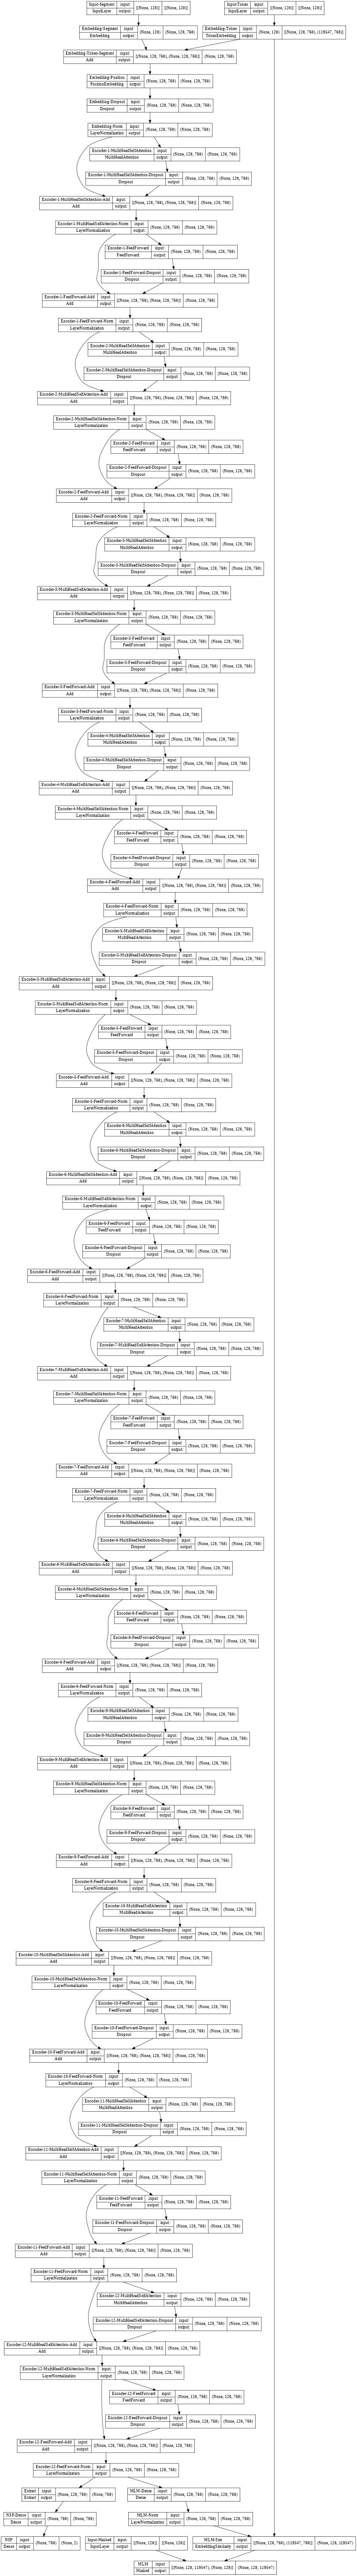

In [32]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=48)

In [37]:
def get_bert_finetuning_model(model):
  inputs = model.inputs[:2]
  dense = model.layers[-3].output

  outputs = keras.layers.Dense(1, activation = 'sigmoid', kernel_initializer = keras.initializers.TruncatedNormal(stddev=0.02),
                              name = 'real_output')(dense) #밑에 두개의 layer를 제외하고 output layer를 붙여줌

  bert_model = keras.models.Model(inputs, outputs)
  Adam = tf.keras.optimizers.Adam(lr=0.00001)
  bert_model.compile(
      optimizer = Adam,
      loss = 'binary_crossentropy',
      metrics = ['accuracy'])
  
  return bert_model

In [34]:
from IPython.display import SVG

In [35]:
from tensorflow.keras.utils import model_to_dot

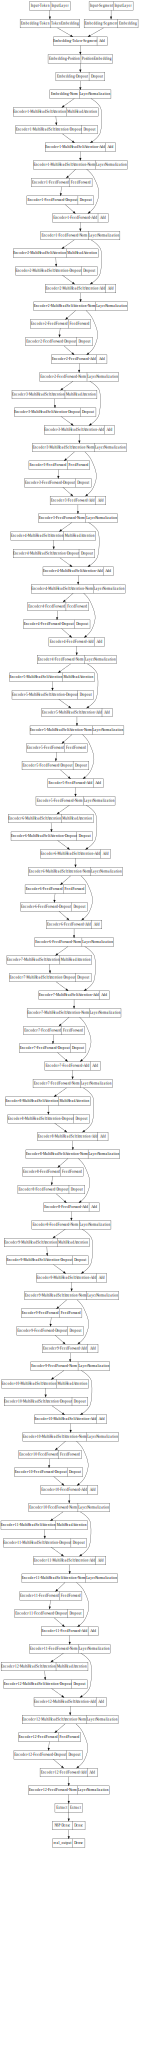

In [38]:
SVG(model_to_dot(get_bert_finetuning_model(model), dpi = 65).create(prog='dot', format='svg'))

In [39]:
bert_model = get_bert_finetuning_model(model)
history = bert_model.fit(train_x, train_y, epochs = 8, batch_size = 16, verbose = 1, shuffle=False)
bert_model.save_weights(path + "/bert1.h5")

Epoch 1/8
41/41 [==============================] - 42s 436ms/step - loss: 0.6954 - accuracy: 0.5564
Epoch 2/8
41/41 [==============================] - 18s 438ms/step - loss: 0.6769 - accuracy: 0.5750
Epoch 3/8
41/41 [==============================] - 18s 440ms/step - loss: 0.6281 - accuracy: 0.6538
Epoch 4/8
41/41 [==============================] - 18s 443ms/step - loss: 0.5115 - accuracy: 0.7697
Epoch 5/8
41/41 [==============================] - 18s 445ms/step - loss: 0.4071 - accuracy: 0.8362
Epoch 6/8
41/41 [==============================] - 18s 447ms/step - loss: 0.3434 - accuracy: 0.8640
Epoch 7/8
41/41 [==============================] - 18s 449ms/step - loss: 0.2854 - accuracy: 0.8949
Epoch 8/8
41/41 [==============================] - 18s 450ms/step - loss: 0.2097 - accuracy: 0.9304


In [42]:
bert_model = get_bert_finetuning_model(model)
bert_model.load_weights(path + "/bert1.h5")

In [43]:
def predict_convert_data(data_df):
    global tokenizer
    indices = []
    for i in tqdm(range(len(data_df))):
        ids, segments = tokenizer.encode(data_df[DATA_COLUMN][i], max_len=SEQ_LEN)
        indices.append(ids)
        
    items = indices
    
    
    indices = np.array(indices)
    return [indices, np.zeros_like(indices)]

def predict_load_data(x): #Pandas Dataframe을 인풋으로 받는다
    data_df = x
    data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)
    data_x = predict_convert_data(data_df)

    return data_x

In [44]:
from sklearn.metrics import classification_report

In [45]:
def get_feature_map(model):
  inputs = model.input
  outputs = model.layers[-2].output
  feature_model = Model(inputs, outputs)
  return feature_model

In [46]:
bert_feature = get_feature_map(bert_model)

In [51]:
labels = train['info']

In [53]:
def predict_convert_data(data_df):
    global tokenizer
    indices = []
    for i in tqdm(range(len(data_df))):
        ids, segments = tokenizer.encode(data_df[DATA_COLUMN][i], max_len=SEQ_LEN)
        indices.append(ids)
        
    items = indices
    
    
    indices = np.array(indices)
    return [indices, np.zeros_like(indices)]

def predict_load_data(x): #Pandas Dataframe을 인풋으로 받는다
    data_df = x
    
    
    data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)


    data_x = predict_convert_data(data_df)

    return data_x

In [54]:
train_set = predict_load_data(train)

100%|██████████| 647/647 [00:00<00:00, 1293.79it/s]


In [55]:
preds = bert_model.predict(train_set)

In [57]:
bert_weight_list = bert_feature.predict(train_set)

In [58]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [60]:
bert_embedded = PCA(n_components=256).fit_transform(bert_weight_list)
bert_embedded = TSNE(n_components=2).fit_transform(bert_embedded)
bert_embedded

array([[ 10.924119 ,  29.060709 ],
       [-15.856881 ,   4.855011 ],
       [ 20.79361  ,  16.089117 ],
       ...,
       [-12.612093 , -21.862574 ],
       [-13.590254 ,  -5.2740083],
       [-21.892687 ,   3.2364047]], dtype=float32)

In [61]:
g=pd.DataFrame(bert_embedded)
g.to_csv("bert_embedded.csv")